In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
from model import Layer, LAYER_TYPE_BOTTOM, LAYER_TYPE_HIDDEN, LAYER_TYPE_TOP, LowPassFilter
from option import Option

In [3]:
class TargetNetwork(object):
    def __init__(self):
        self.w0 = np.random.uniform(-1, 1, size=(20,30))
        self.w1 = np.random.uniform(-1, 1, size=(10,20))

    def softplus(self, x):
        return np.log(1.0 + np.exp(x))

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def get_training_pair(self):
        input_values = np.random.rand(30)
        h0 = self.softplus(self.w0.dot(input_values))
        target_values = self.sigmoid(self.w1.dot(h0))
        return input_values, target_values
        

class Network(object):
    def __init__(self, force_self_prediction=False):
        option = Option()

        self.layers = [None] * 3
        self.layers[0] = Layer(pd_unit_size=30, 
                               layer_type=LAYER_TYPE_BOTTOM,
                               option=option,
                               force_self_prediction=force_self_prediction)
        self.layers[1] = Layer(pd_unit_size=20,
                               layer_type=LAYER_TYPE_HIDDEN,
                               option=option,
                               force_self_prediction=force_self_prediction)
        self.layers[2] = Layer(pd_unit_size=10,
                               layer_type=LAYER_TYPE_TOP,
                               option=option,
                               force_self_prediction=force_self_prediction)
        
        self.layers[0].connect_to(self.layers[1])
        self.layers[1].connect_to(self.layers[2])

    def update(self, dt):
        for layer in self.layers:
            layer.update_potential(dt)

        for layer in self.layers:
            layer.update_weight(dt)

    def set_input_firing_rate(self, values):
        self.layers[0].set_input_firing_rate(values)

    def set_target_firing_rate(self, values):
        self.layers[2].set_target_firing_rate(values)

    def clear_target(self):
        self.layers[2].clear_target()

    def load(self, dir_name):
        for i in range(2):
            # Top層はLoadするものが無いので対象外
            file_path = os.path.join(dir_name, "layer{}".format(i))
            self.layers[i].load(file_path)

        print("loaded: {}".format(dir_name))        

In [6]:
network = Network(force_self_prediction=True)
target_network = TargetNetwork()
    
network.load("saved")
    
dt = 0.1
lp_filter = LowPassFilter(dt, 3)

targets = []
outputs = []

for i in range(100):
    input_values, target_values = target_network.get_training_pair()
    for j in range(1000):
        filtered_input_values = lp_filter.process(input_values)
        network.set_input_firing_rate(filtered_input_values)
        network.update(dt)
        
        targets.append(target_values[1])
        outputs.append(network.layers[2].get_p_activation()[1]);
    #print("target_r={}".format(target_values))
    #print("output_r={}".format(network.layers[2].get_p_activation()))

weight loaded: saved/layer0.npz
weight loaded: saved/layer1.npz
loaded: saved


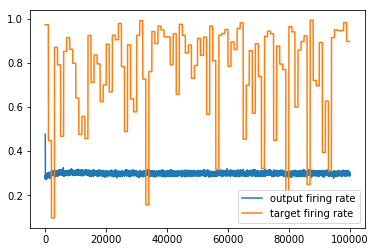

In [7]:
plt.plot(outputs, label="output firing rate")
plt.plot(targets, label="target firing rate")
plt.legend()
plt.show()